# Machine Learning With `torch`

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from functools import partial
from tqdm import tqdm

In [3]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [4]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [5]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

In [1]:
from tools.text import generate_sequences

## PyTorch (`torch`)

Now we're moving on to `torch`, a very popular machine learning framework, probably the most popular nowadays. A lot of waht `torch` does underneath is defining a bunch of "kernels" that do particular functions, such as multiplying two `float` tensors together, and properly dispaching these at runtime. It also computes gradients, which we'll talk about in a bit.

Like `jax`, torch implements an interface very similar to that of `numpy`. However, instead of being basically a drop in replacement, there are some differences and all the functions are exposed directly in the top-level `torch` module. First, arrays aren't called `array` anymore, they're called `tensor`. As with `jax`, you need to be a little more careful about array types, as most things are done in 32-bit, and arrays always have a device that they are located on, which can be either `cpu` or `cuda` most of the time.

In [6]:
x = torch.tensor([1.0, 2.0, 3.0])
print(x.device, x.dtype)
x

cpu torch.float32


tensor([1., 2., 3.])

As an example, in `numpy` and `jax`, you can take the mean of an integer or boolean array. However, in `torch` this will throw an error, as `mean` would then return a number of a different type (`float`). Here's an example

In [7]:
try:
    b = torch.tensor([1, 2, 3])
    b.mean()
except Exception as e:
    print(e)

mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long


To get around this, we have to cast the tensor to a `float` first. We could also convert it to a `numpy` array, then do the mean.

In [8]:
print(b.float().mean())
print(b.numpy().mean())

tensor(2.)
2.0


We'll want to find the mean of some boolean arrays below, so let's define a convenience function. Also note that below we use chaining of functions on tensors, which is quite common in `torch` world, rather than top-level `torch` functions.

In [9]:
bool_mean = lambda x: x.float().mean()

### Autograd

Let's define a custom sum-of-squares loss. This is just for fun, we already have this built in as `torch.nn.MSELoss`.

In [10]:
def f(x):
    return x.square().sum()

Then let's define a Tensor `x` and explicitly pass `requires_grad=True` on creation. Then we run the function ("forward") and then call `.backward()` right afterwards, our gradients show up in `x.grad` with the correct values.

In [11]:
x = torch.arange(5, dtype=torch.float, requires_grad=True)
y = f(x)
y.backward()
x.grad

tensor([0., 2., 4., 6., 8.])

What's happening here is that during the forward call, because it can see that `x` is requesting gradients, it computes not only the function values but the chain rule terms that are later used to construct the gradient. Because of this speed and especially memory usage are going to get worse, as we're keeping these terms in memory. Next, when we call `backward` it goes through and multiplies all of the accumulated chain rule terms together for a final answer. Note that `torch` can only handle doing this for scalar-valued functions, though `x` can be any shape you want, it just has to be a floating point type. There are some helper functions and classes that we'll use below to make this process a bit easier.

## Linear Regression

Here we're considering the case of a linear model with Guassian noise. In this case, the likelihood function looks like

$$
\log(\mathcal{L}) = -\frac{N}{2}\log(2\pi)-N\log(\sigma)-\sum_i \frac{1}{2}\left(\frac{y_i-\beta x_i}{\sigma}\right)^2
$$

For our purposes, it is sufficient to simply maximize the sum (or mean) of the squared errors. We can back out $\sigma$ later on if we want. First let's generate some random data.

In [12]:
# generate random data
N = 10000
β0, β1, σ = 1.0, 2.0, 0.5
dat_x = torch.randn(N)
dat_y = β0 + β1*dat_x + σ*torch.randn(N)

Now we'll make a `Module` that computes a linear predictor. In `torch` land a `Module` is a way to keep track of a particular operation and it's associated parameters. In the constructor, you create any `Parameter` values you'll need, then in `forward` you actually do the computation. Even the most complex models, such as a GPT, are just aggregations of these `Module`s. In most real models, the parameters are actually multi-dimensional arrays, but we're keeping it simple for now.

In [13]:
class Linear1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.β0 = nn.Parameter(torch.tensor(0.0))
        self.β1 = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        return self.β0 + self.β1 * x

Then we implement a basic optimization loop. Here we compute the linear predictor and associated loss, then accumulate gradients and apply them with our optimizer (in this case `RMSprop`). Note that the call to `item` below has two purposes: to turn a 1-D `tensor` into a regular scalar and to make sure we don't track gradients needlessly.

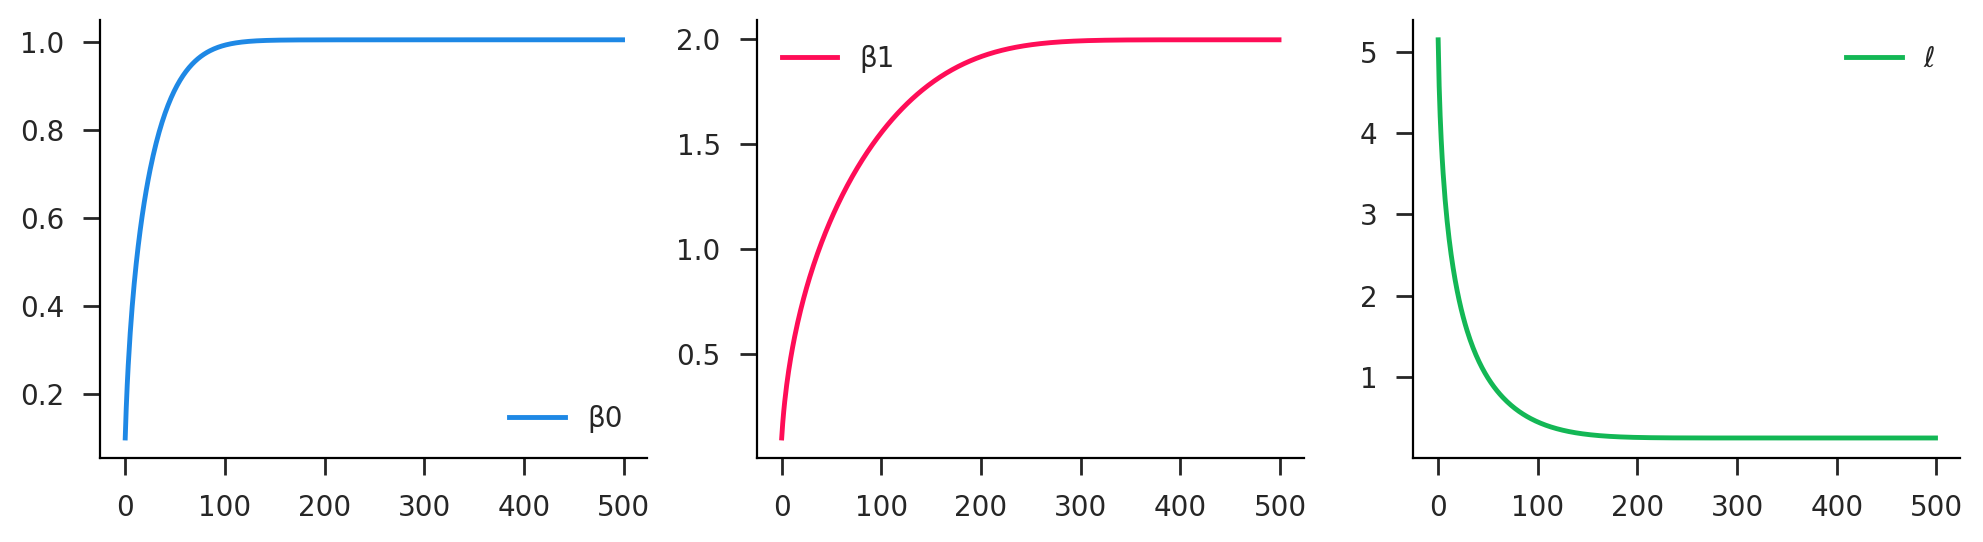

In [14]:
# set up optimization
model = Linear1D()
loss = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), lr=0.01)
history = []

# loop a bunch of times
for i in range(500):
    # compute loss
    yhat = model(dat_x)
    like = loss(yhat, dat_y)

    # update params
    optim.zero_grad()
    like.backward()
    optim.step()
    
    # store history
    history.append([
        model.β0.item(), model.β1.item(), like.item()
    ])

# plot history
hist = pd.DataFrame(history, columns=['β0', 'β1', 'ℓ'])
hist.plot(subplots=True, layout=(1, 3), figsize=(12, 3));

Note that here we compute the loss and its gradients for the entire dataset. This is unusual, and for large datasets would cause issues of memory usage. From now on we'll break the dataset into batches and loop over those.

## Neural Networks

Now let's reimplement a neural classifier model in `torch`. The data generation is nearly identical to before. Note that `categ` is a boolean but is encoded as an `int` here. After generating the raw data, we pass it to `TensorDataset` to create a single dataset object. This way we don't have to carry around multiple tensors. Then we pass this to `DataLoader`, which takes care of things like randomly shuffling the data and making batches. If you use the dataloader object as an iterator, it will return batches of `space`/`categ` pairs.

In [16]:
# simple hyperplane model
dim = 100
lβ0 = 0.0
lβ1 = 1.0*torch.ones(dim)

In [17]:
# generate raw data
N = 10000
space = torch.randn(N, dim)
rando = torch.tensor(np.random.logistic(size=N))
categ = (lβ0 + space @ lβ1 + rando > 0).long()

In [23]:
# make dataset and loader
dataset = torch.utils.data.TensorDataset(space, categ)
dataload = torch.utils.data.DataLoader(dataset, batch_size=1000)

Now let's create the actual model, which is a `Module` object. Notice that here we also return a pair of logits that defines the probabilities of the respective outcomes (`0` and `1`).

In [24]:
# same neural as a module
class Neural(nn.Module):
    def __init__(self, hid=2):
        super().__init__()
        self.linear0 = nn.Linear(dim, hid)
        self.linear1 = nn.Linear(hid, 2)

    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        return x

We want to track some performance metrics with each iteration. Sadly, we don't have trees in `torch` world, so we just make a `tensor` of stats.

In [25]:
def neural_stats(logits, y):
    predict = logits[:, 1] >= logits[:, 0]
    target = y == 1
    return torch.tensor([
        bool_mean(predict == target),
        bool_mean(predict & ~target),
        bool_mean(~predict & target),
    ])

Now let's run it! There's a lot going on in this cell. You can see it's not so simple and elegant as in `jax`. Some of this is for the sake of performance. We don't have to do anything like `jit` here, but things are still pretty fast, and the cost is slightly clunkier notation.

Note the use of the `logits.detach()` command. This actually isn't truly necessary, we could have just written `logit`. All that `detach` does it tell it to stop tracking gradient information for that calculation, as we don't need the gradients for the `neural_stats` values. Similarly, the `numpy` command converts a tensor into the analgous `numpy` array.

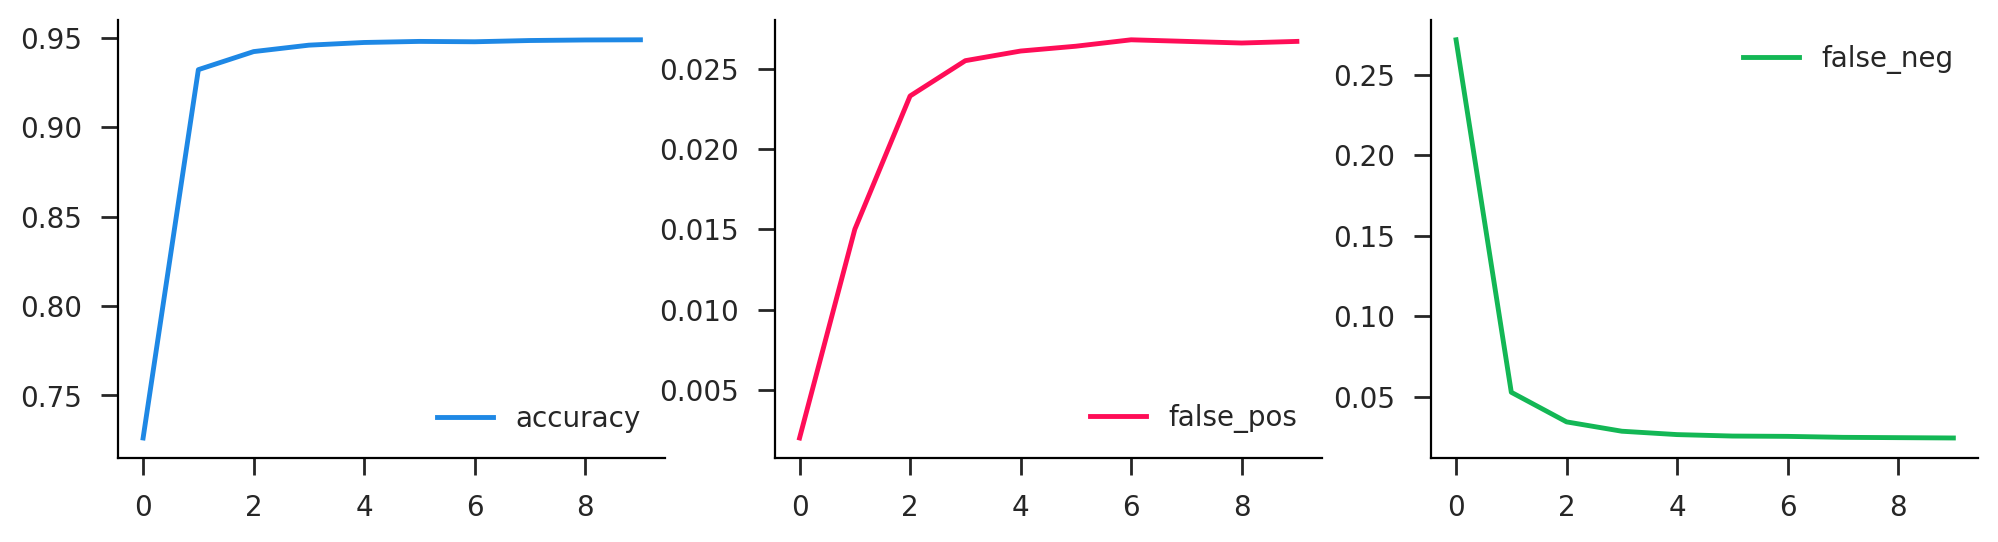

In [27]:
# make model and optimizer
model = Neural()
optim = torch.optim.RMSprop(model.parameters(), lr=0.01)
bce_loss = nn.CrossEntropyLoss()
history = []

# go for many iterations
for i in range(10):
    # accumulate stats per batch
    nbatch = 0
    stats = torch.zeros(3)

    # iterate over batches
    for x, y in dataload:
        # compute loss
        logits = model(x)
        loss = bce_loss(logits, y)

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        stats += neural_stats(logits.detach(), y)

    # make it a mean    
    stats /= nbatch
    history.append(stats)

# turn history into dataframe
history = pd.DataFrame(
    torch.stack(history).numpy(),
    columns=['accuracy', 'false_pos', 'false_neg']
)
history.plot(subplots=True, layout=(1, 3), figsize=(12, 3));

### Neural Trader

Okay, time to make some money!! We're going to generate some data on "returns", which are just random normals, which may or may not have a predictable component. There is a single security, so our choice is what fraction of our money to invest in each period. We're assuming we can only take "long" positions, so this is a number $s \in [0,1]$. Our input data is the history of the past $L$ realizations of returns. From a single series of length $T$, we can turn this into a set of $T-L$ overlapping history/outcome pairs.

In [28]:
# parameters
N = 1000 # number of training series
M = 100 # number of validation series
T = 20 # total time length
L = 4 # history window length
K = T - L # number of subseries

The model is a two layer neural network as before. The output for each observation is a scalar in $[0,1]$, which we accomplish with the `sigmoid` on output. Note that that final `squeeze` operation makes sure it's a scalar rather than a length-1 tensor.

In [30]:
# simple neural trader (long only)
class NeuralTrader(nn.Module):
    def __init__(self, lag=4, hid=5):
        super().__init__()
        self.linear0 = nn.Linear(lag, hid)
        self.linear1 = nn.Linear(hid, 1)

    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

Now it is time to train. This is all quite similar to before. Notice the objective here is just the product of the position recommendation and the realized returns (averaged over the batch). One addition you'll notice is we wrap the epoch loop in the mysterious `tqdm`. This will function the same in the code but will also print out a neat little progress bar. Also, there are new `model.train()` and `model.eval()` commands. These are unecessary in the basic case, but we'll need them later.

In [31]:
def neural_trader(model, train_data, valid_data, lr=0.01, epochs=25, batch_size=1000):
    # make data loaders
    train_load = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_x, valid_y = valid_data.tensors

    # make model and optimizer
    optim = torch.optim.RMSprop(model.parameters(), lr=lr)

    # track history
    history = []

    # go for many iterations
    for i in tqdm(range(epochs)):
        n_batch = 0
        train_stats = torch.zeros(2)
        
        # iterate over batches
        model.train()
        for batch_x, batch_y in train_load:
            # compute loss
            recom = model(batch_x)
            retvrn = recom*batch_y
            loss = -retvrn.mean()

            # update params
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # training stats
            n_batch += 1
            train_stats += torch.tensor([recom.detach().mean(), retvrn.detach().mean()])

        # average training
        train_stats /= n_batch

        # validation stats
        model.eval()
        valid_recom = model(valid_x)
        valid_retvrn = valid_recom*valid_y
        valid_stats = torch.tensor([valid_recom.detach().mean(), valid_retvrn.detach().mean()])

        # make it a mean
        stats = torch.cat([train_stats, valid_stats])
        history.append(stats)

    # turn history into dataframe
    names = ['train_recom', 'train_return', 'valid_recom', 'valid_return']
    return pd.DataFrame(torch.stack(history).numpy(), columns=names)

### Overfitting

Now let's train this on some random data. Any returns we get should be purely noise, as these are just uncorrelated returns over time. You can see that we typically get 1-2% returns on the training data, while those in the validation set are over lower, but in general are quite noisy. The other thing to note is that for many runs, after some point in the training process we see the validation return start to go down, while the training return continues to rise. This is a classic signature of overfitting.

In [38]:
# generate training data
train_random_return = torch.randn(N, T)
train_random_series, train_random_target = generate_sequences(train_random_return, L)
train_random_data = torch.utils.data.TensorDataset(train_random_series, train_random_target)

# generate validation data
valid_random_return = torch.randn(M, T)
valid_random_series, valid_random_target = generate_sequences(valid_random_return, L)
valid_random_data = torch.utils.data.TensorDataset(valid_random_series, valid_random_target)

100%|█████████████████████████████████████████| 500/500 [00:42<00:00, 11.74it/s]


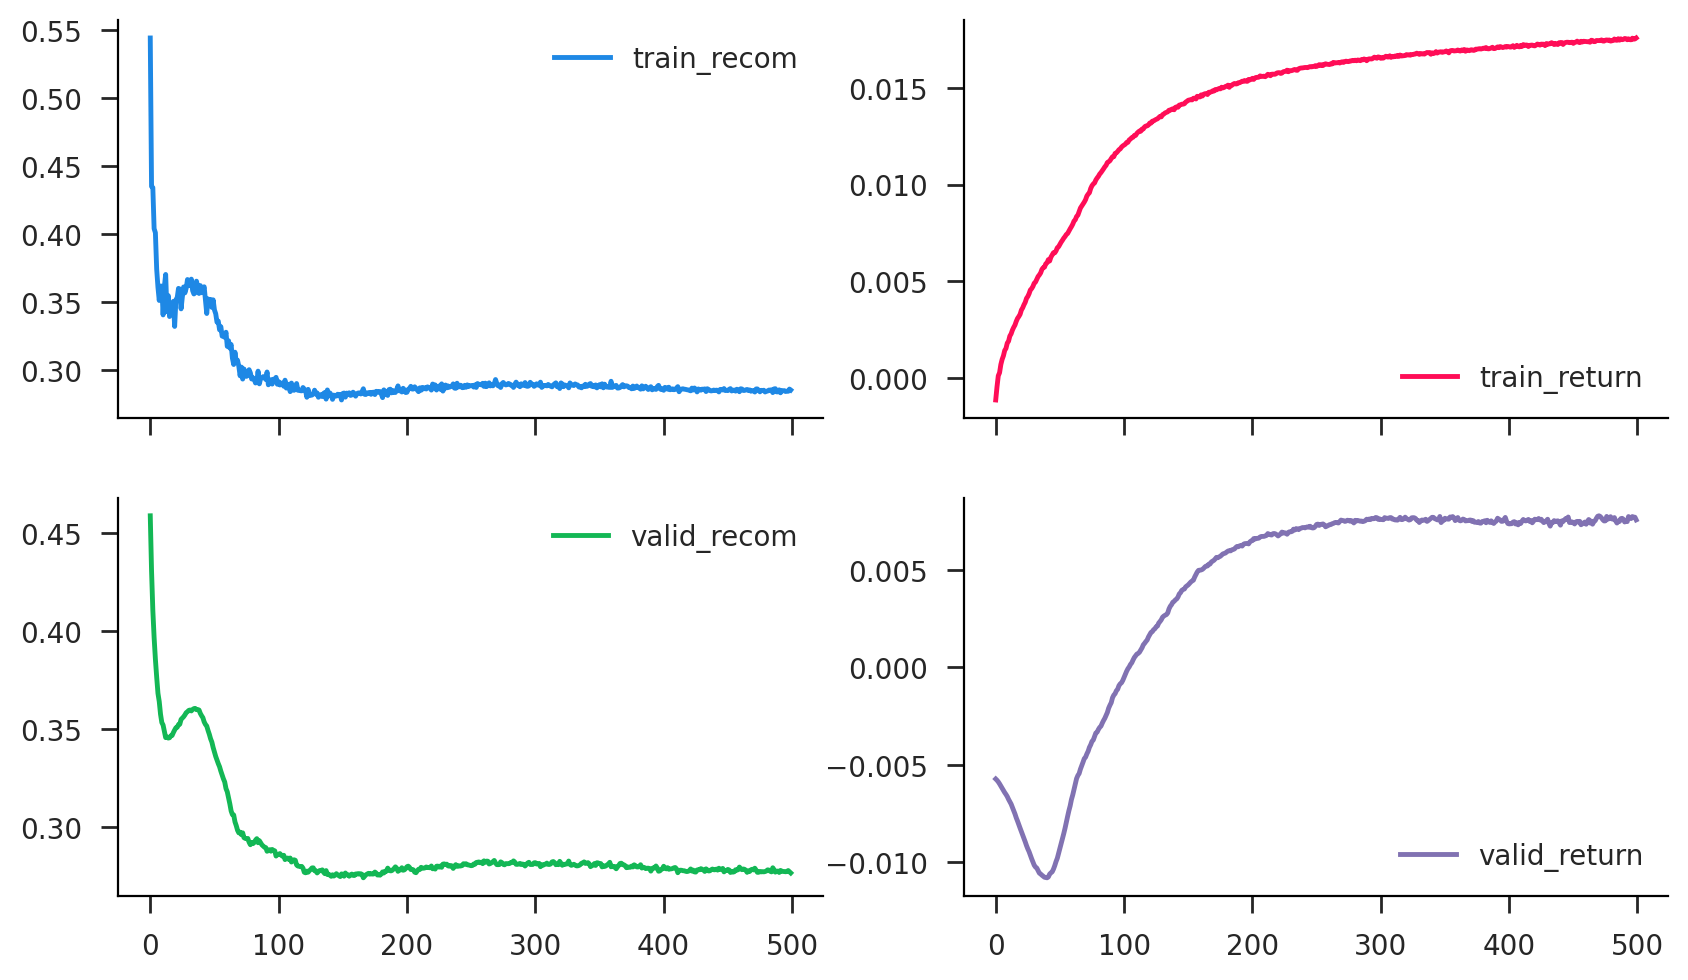

In [39]:
model_base = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_base, train_random_data, valid_random_data, epochs=500)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

### Real Signal (Momentum)

Now let's at least give ourselves a chance and add in some momentum (EMH violation alert!). Obivously this can happen in certain markets, and I think there's even an explanation in efficient markets relating to stochastic discount factors. Like it's okay as long as returns are uncorrelated with the SDF. Anyway, that doesn't matter here, we can simulate whatever the hell we want.

In [26]:
# draw an MA(1) process with persistence ρ
def gen_ma1(N, T, ρ=0.5):
    tvec = torch.arange(T).flip(0)
    ρvec = (ρ**tvec).unsqueeze(0)
    shocks = torch.randn(N, T)
    values = (ρvec*shocks).cumsum(1)/ρvec
    return values

In [27]:
ρ = 0.2
train_moment_return = gen_ma1(N, T, ρ=ρ)
train_moment_series, train_moment_target = generate_sequences(train_moment_return, L)
train_moment_data = torch.utils.data.TensorDataset(train_moment_series, train_moment_target)
valid_moment_return = gen_ma1(M, T, ρ=ρ)
valid_moment_series, valid_moment_target = generate_sequences(valid_moment_return, L)
valid_moment_data = torch.utils.data.TensorDataset(valid_moment_series, valid_moment_target)

100%|█████████████████████████████████████████| 250/250 [00:12<00:00, 19.49it/s]


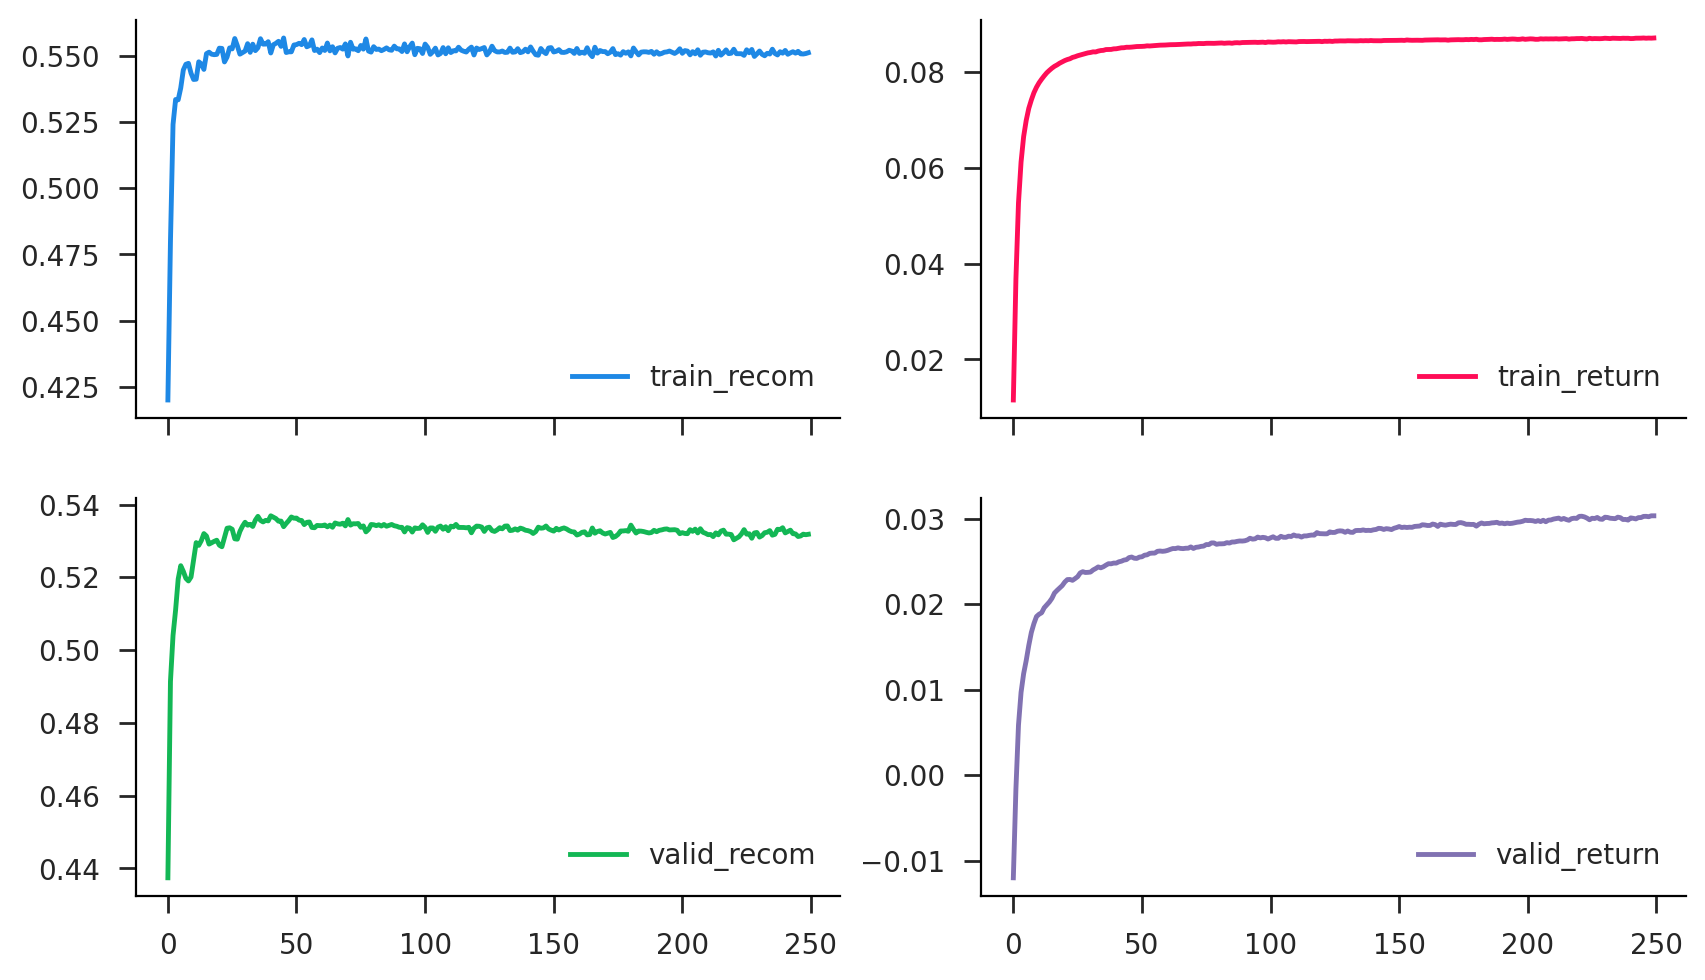

In [28]:
model_moment = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_moment, train_moment_data, valid_moment_data, epochs=250)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

### Dropout

We may be worried about what appears to be overfitting. The algorithm is just fitting noise. One popular approach to this is to use a method called "dropout" in which network connections are randomly severed during training (weights zeroed). This forces the algorithm to "diversify" and ideally reduces overfitting.

In [29]:
# simple neural trader (long only)
class DropoutTrader(nn.Module):
    def __init__(self, lag=4, hid=5, drop=0.5):
        super().__init__()
        self.linear0 = nn.Linear(lag, hid)
        self.linear1 = nn.Linear(hid, 1)
        self.dropout = nn.Dropout(drop)
        self.drop = drop

    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.85it/s]


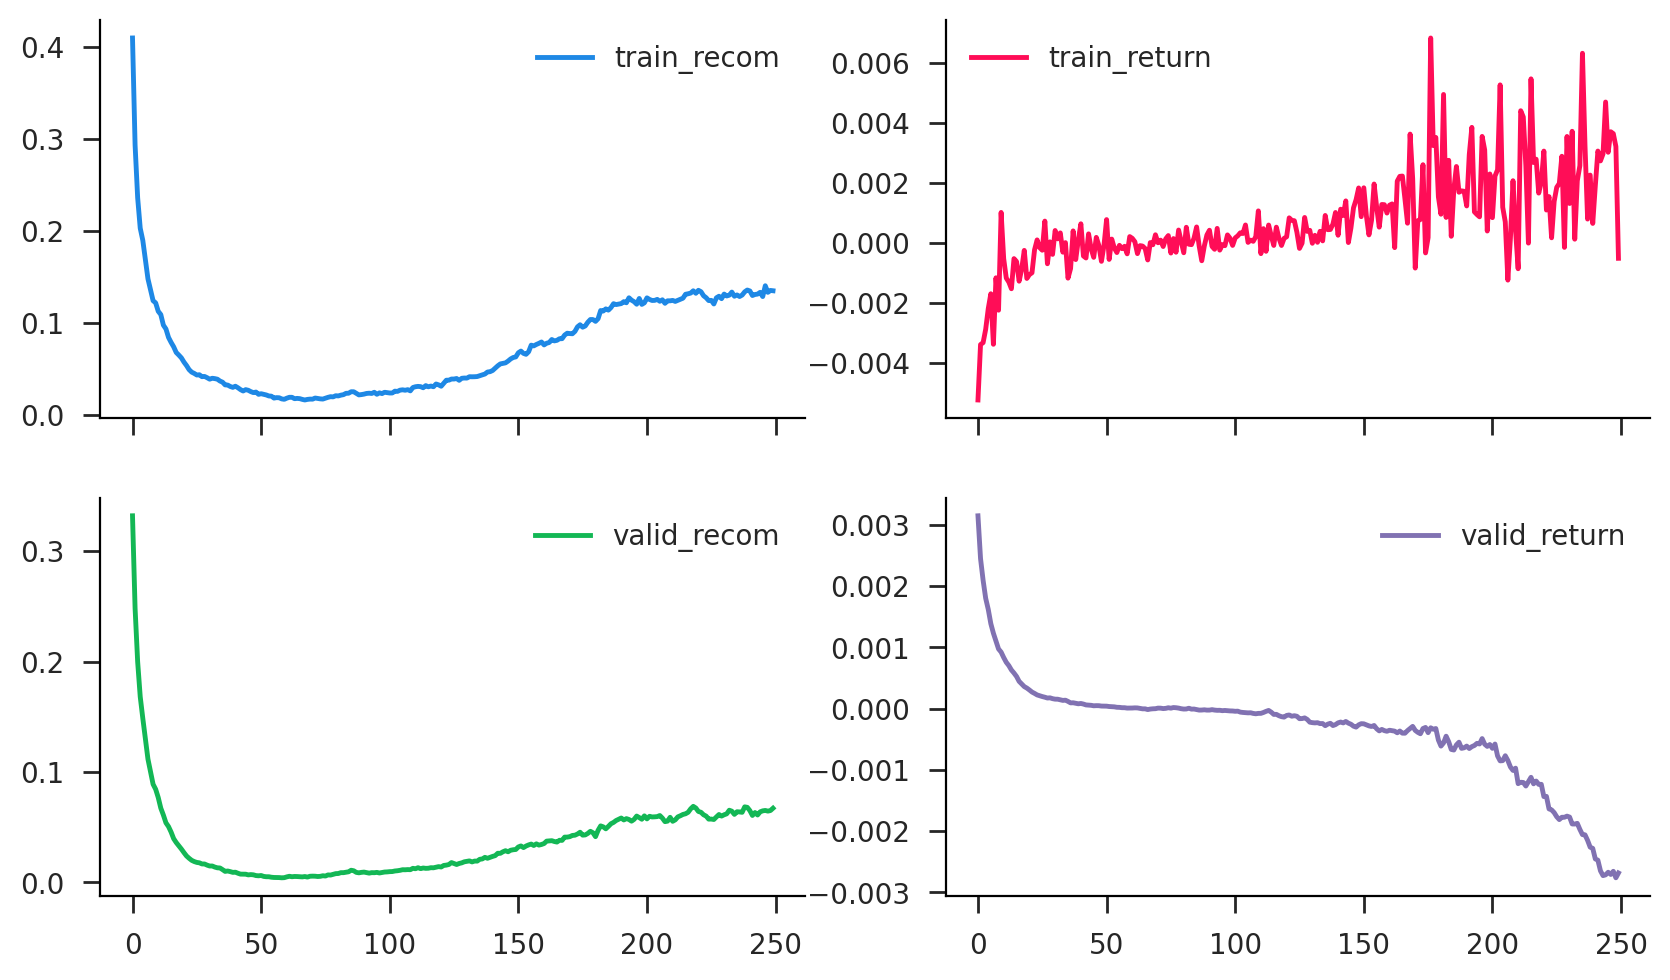

In [30]:
model_random_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_random_dropout, train_random_data, valid_random_data, epochs=250)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

100%|█████████████████████████████████████████| 250/250 [00:14<00:00, 17.08it/s]


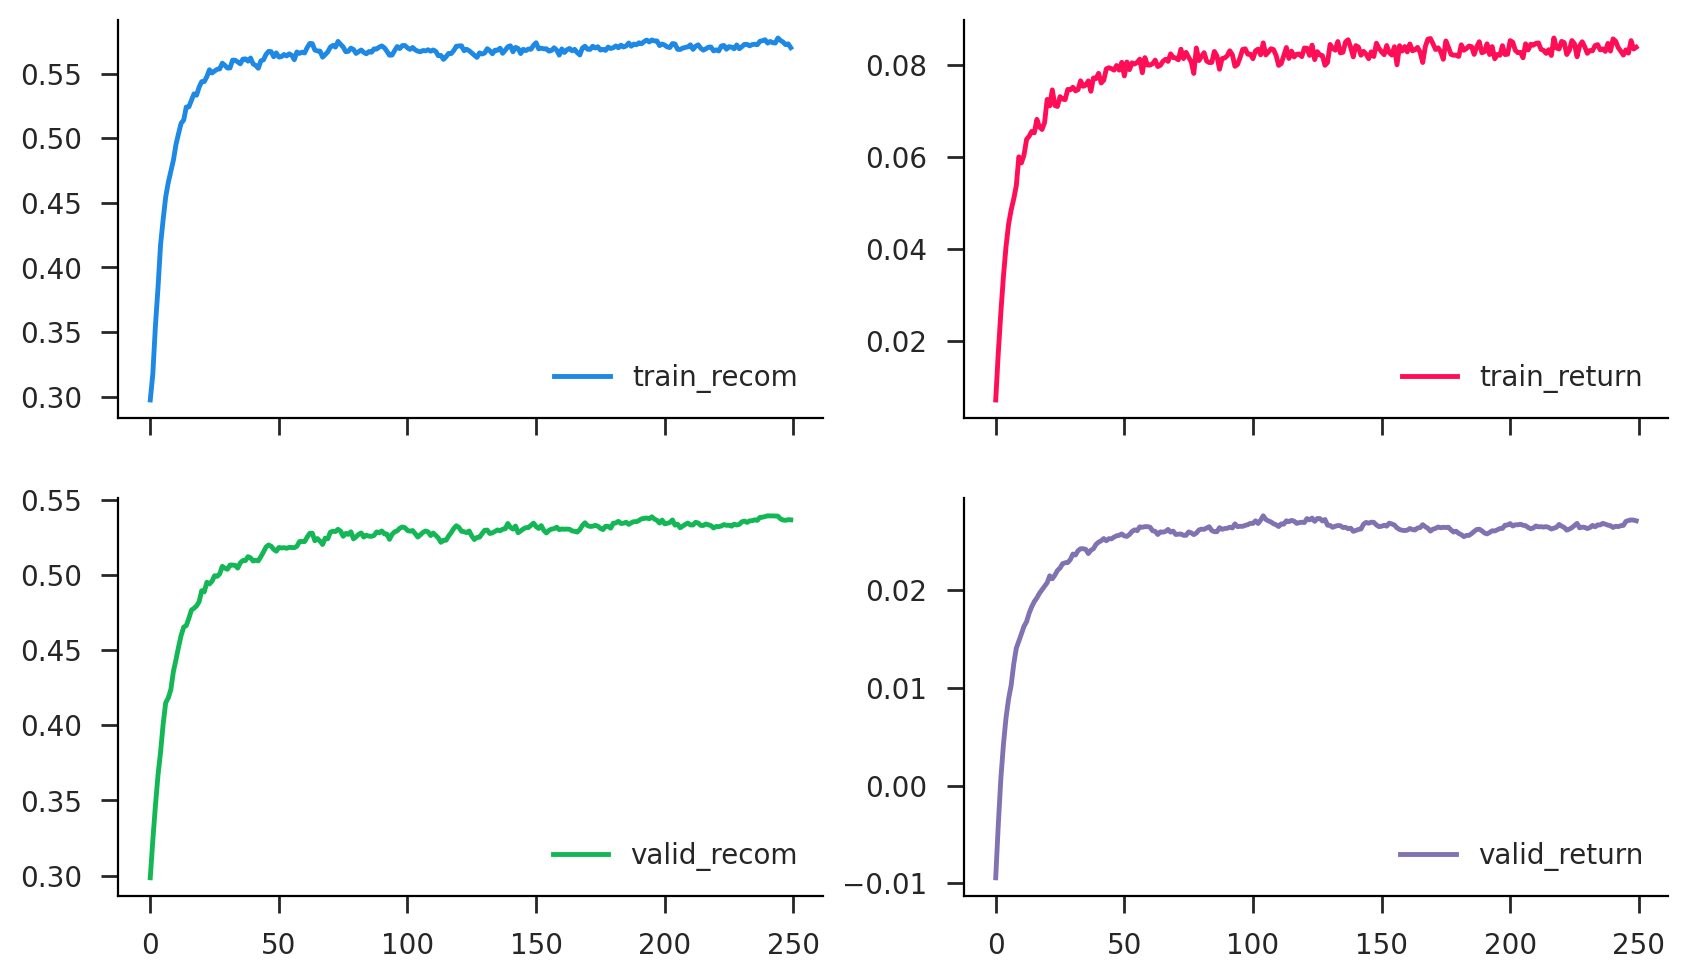

In [31]:
model_moment_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_moment_dropout, train_moment_data, valid_moment_data, epochs=250)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));